**DATA PREPROCESSING**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Load the dataset
df = pd.read_csv('/content/beautified_indian_travel_dataset.csv')


In [3]:
# Check for duplicates and remove them
df = df.drop_duplicates()

In [4]:
# Handle missing values if any
df = df.dropna()

In [5]:
# Convert budget range to numerical values (taking the average)
df['Budget_min'] = df['Budget Range (USD)'].apply(lambda x: int(x.split('–')[0]))
df['Budget_max'] = df['Budget Range (USD)'].apply(lambda x: int(x.split('–')[1]))
df['Budget_avg'] = (df['Budget_min'] + df['Budget_max']) / 2

In [6]:

# Encode categorical variables
label_encoders = {}
categorical_cols = ['Place Name', 'Location', 'Visit Intention']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [7]:
# Create a month with highest temperature feature
month_cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['Max_Temp'] = df[month_cols].max(axis=1)
df['Avg_Temp'] = df[month_cols].mean(axis=1)

In [8]:
# Prepare features and target
X = df[['Place Name', 'Location', 'Budget_avg', 'Max_Temp', 'Avg_Temp']]
y = df['Visit Intention']

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Scale numerical features
scaler = StandardScaler()
X_train[['Budget_avg', 'Max_Temp', 'Avg_Temp']] = scaler.fit_transform(X_train[['Budget_avg', 'Max_Temp', 'Avg_Temp']])
X_test[['Budget_avg', 'Max_Temp', 'Avg_Temp']] = scaler.transform(X_test[['Budget_avg', 'Max_Temp', 'Avg_Temp']])

DATA **VISUALIZATION**

In [11]:
# Set style
plt.style.use('ggplot')

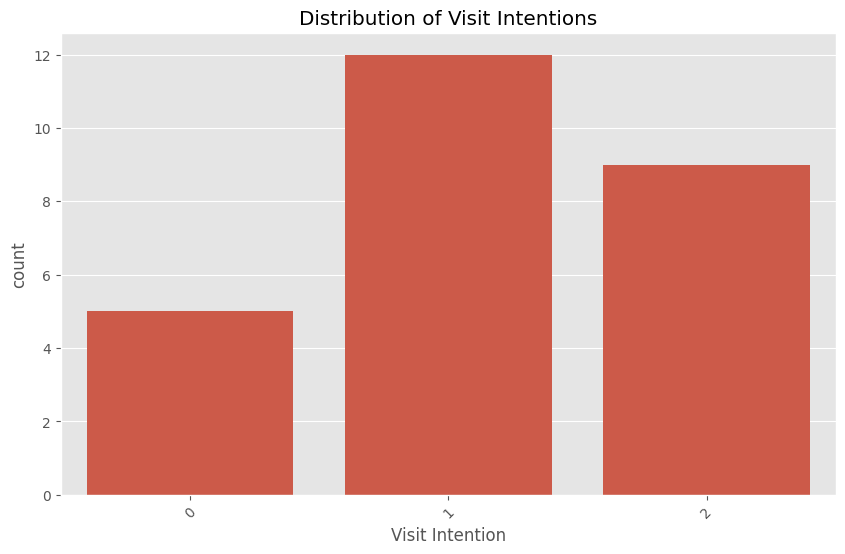

In [12]:
# 1. Visit Intention Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Visit Intention', data=df)
plt.title('Distribution of Visit Intentions')
plt.xticks(rotation=45)
plt.show()

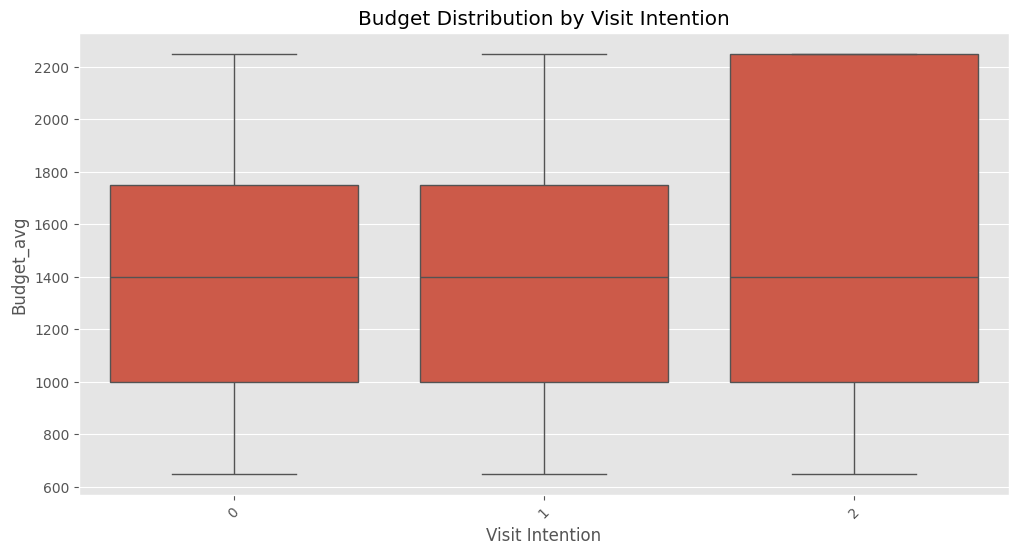

In [13]:

# 2. Budget Range by Visit Intention
plt.figure(figsize=(12, 6))
sns.boxplot(x='Visit Intention', y='Budget_avg', data=df)
plt.title('Budget Distribution by Visit Intention')
plt.xticks(rotation=45)
plt.show()

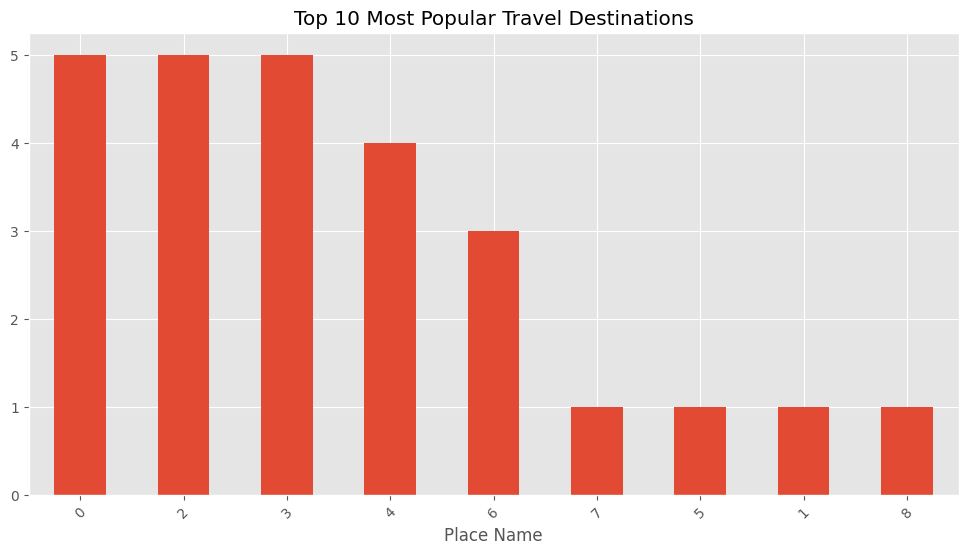

In [14]:

# 3. Popular Locations
plt.figure(figsize=(12, 6))
top_locations = df['Place Name'].value_counts().head(10)
top_locations.plot(kind='bar')
plt.title('Top 10 Most Popular Travel Destinations')
plt.xticks(rotation=45)
plt.show()

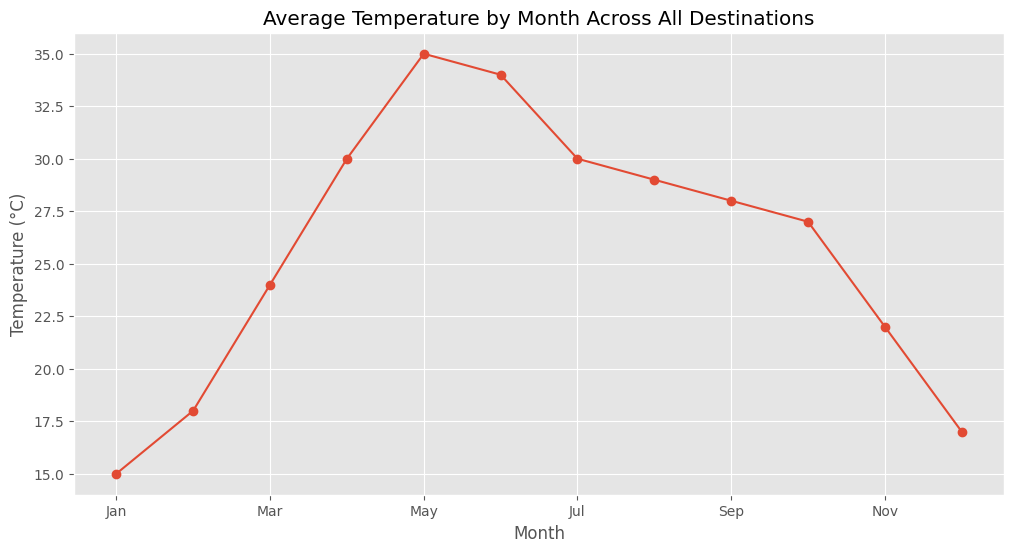

In [15]:
# 4. Temperature Analysis
plt.figure(figsize=(12, 6))
df[month_cols].mean().plot(kind='line', marker='o')
plt.title('Average Temperature by Month Across All Destinations')
plt.ylabel('Temperature (°C)')
plt.xlabel('Month')
plt.show()

ML **MODAL**

In [16]:
# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsClassifier()
}


In [17]:

# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })


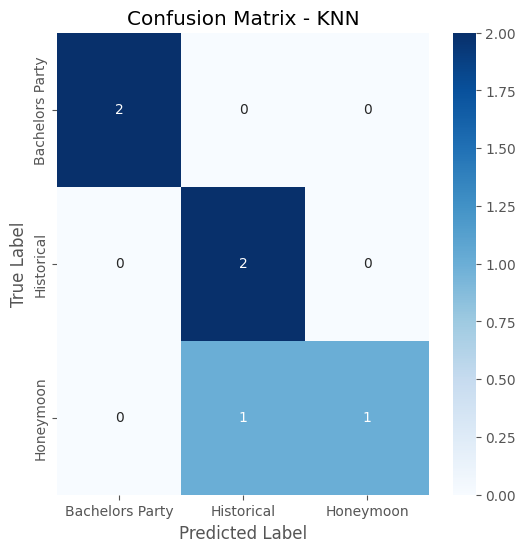

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoders['Visit Intention'].classes_,
            yticklabels=label_encoders['Visit Intention'].classes_)
plt.title(f'Confusion Matrix - {name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

<Figure size 1200x800 with 0 Axes>

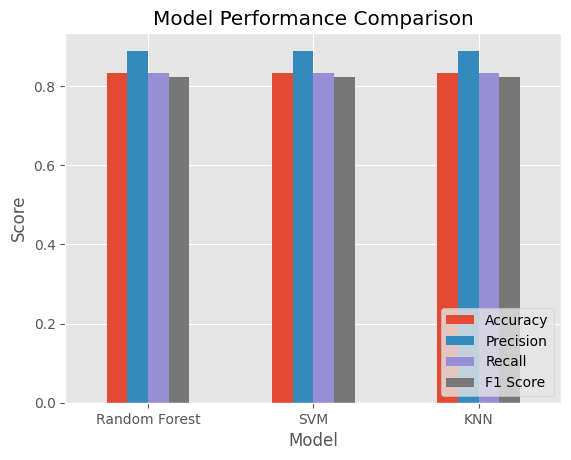

In [19]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot model comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(12, 8))
results_df.set_index('Model')[metrics].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

RECOMENDATION **FUNCTION**

In [20]:
def recommend_places(budget, intention, preferred_temp=None):
    """
    Recommends travel destinations based on user preferences

    Parameters:
    - budget: User's budget in USD
    - intention: 'Historical', 'Honeymoon', or 'Bachelors Party'
    - preferred_temp: Preferred temperature range (optional)
    """
    # Encode the intention
    intention_encoded = label_encoders['Visit Intention'].transform([intention])[0]

    # Prepare input data
    input_data = pd.DataFrame({
        'Place Name': [0] * len(df),  # Dummy value, will be ignored
        'Location': [0] * len(df),    # Dummy value
        'Budget_avg': [budget] * len(df),
        'Max_Temp': df['Max_Temp'],
        'Avg_Temp': df['Avg_Temp']
    })

    # Scale the input
    input_data[['Budget_avg', 'Max_Temp', 'Avg_Temp']] = scaler.transform(
        input_data[['Budget_avg', 'Max_Temp', 'Avg_Temp']])

    # Get predictions from the best model (Random Forest in this case)
    rf_model = models['Random Forest']
    predictions = rf_model.predict(input_data)

    # Filter places that match the intention
    matching_indices = np.where(predictions == intention_encoded)[0]
    matching_places = df.iloc[matching_indices]

    # Filter by budget
    matching_places = matching_places[
        (matching_places['Budget_min'] <= budget) &
        (matching_places['Budget_max'] >= budget)]

    # Filter by temperature if specified
    if preferred_temp:
        matching_places = matching_places[
            (matching_places['Avg_Temp'] >= preferred_temp[0]) &
            (matching_places['Avg_Temp'] <= preferred_temp[1])]

    # Get unique places (remove duplicates)
    unique_places = matching_places.drop_duplicates(subset=['Place Name'])

    # Decode place names
    unique_places['Place Name'] = label_encoders['Place Name'].inverse_transform(unique_places['Place Name'])

    return unique_places[['Place Name', 'Location', 'Budget Range (USD)', 'Best Food to Try',
                         'Famous Places to Visit', 'Budget Hotel', 'Mid-Range Hotel',
                         'Luxury Hotel', 'Avg_Temp']]

# Example usage
print(recommend_places(budget=1000, intention='Honeymoon'))

Empty DataFrame
Columns: [Place Name, Location, Budget Range (USD), Best Food to Try, Famous Places to Visit, Budget Hotel, Mid-Range Hotel, Luxury Hotel, Avg_Temp]
Index: []
